# UK Data Science Job Analysis

## Objective

To analyse data scraped from Indeed.co.uk for jobs matching the query "Data Scientist". Aiming to answer these 5 questions:

1. What are the most requested skills/technologies for a Data Scientist position?
2. Where are Data Scientist roles located across the UK?
3. Do roles tend to be permanent or contract/temporary roles


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from markdownify import markdownify
import re
import math
import requests
import bs4
from tqdm import trange
import wordcloud
from IPython.core.display import HTML
import json
import nltk

In [2]:
# file names for pickle files
file_name = 'indeed_scrape_20200822.pkl'

preprocessed_file_name = file_name.replace('.pkl','_preprocessed.pkl')

In [3]:
 def scrape_indeed_job_ids(query):
    """
    Run a job search query on the Indeed.co.uk website and for returning results.
    
    Iterate through the paginated results (50 at a time which was found to be the maximum) building an array of unique job_id to be returned.
    
    The job ids can be used in later calls to gather job details such as job title, expected salary, skills etc.

    args:
        query: the search query for jobs that you wish to run e.g. "Data Scientist"

    returns:
        array of str which are the job_ids
    """
    
    query = query.replace(' ','+')
    
    pc_re = re.compile('\s+Page (?P<current_job_no>[\d,]+) of (?P<job_count>[\d,]+) jobs')

    job_ids = []
    
    page = 0
    page_count = 1

    while page < page_count:
        if page == 0:
            resp = requests.get(f'https://www.indeed.co.uk/jobs?q={query}&limit=50')
            bs = bs4.BeautifulSoup(resp.text, 'html.parser')
            result = pc_re.match(bs.select('#searchCountPages')[0].text)
            
            if result:
                job_count = result.group('job_count').replace(',','')
                page_count = math.ceil(int(job_count)/50)
            else:
                raise Exception('Could not parse page_count/job_count')
        else:
            resp = requests.get(f'https://www.indeed.co.uk/jobs?q=data+scientist&limit=50&start={page*50}')
            bs = bs4.BeautifulSoup(resp.text, 'html.parser')
        
        job_ids += [div['id'][div['id'].find('_')+1:] for div in bs.select('div.row.result')]
        
        page+=1

    return list(set(job_ids))

def scrape_indeed_job_details(job_id):
    """
    For the given job_id scrape the specific job details using the first json call.
    
    Next request the full page for the job_id to enable scraping of the job description plain text and html
    
    args:
        job_id: the job id to scrape details for
        
    Returns:
        dict
    """
    resp = requests.get(f'https://www.indeed.co.uk/viewjob?jk={job_id}&from=vjs&vjs=1')
    
    job_json = resp.json()

    job = {}

    job['job_id'] = job_id
    job['json'] = job_json
    job['title'] = job_json['jobTitle']
    job['hiring_organization'] = job_json['sicm']['cmN']
    job['location'] = job_json['jobLocation']
    try:
        job['salary_expectation_average'] = job_json['sEx']['sAvg']
    except:
        job['salary_expectation_average'] = np.nan

    try:
        job['salary_expectation_range'] = job_json['sEx']['sRg']
    except:
        job['salary_expectation_range'] = np.nan
        
    try:
        job['salary_expectation_per'] = job_json['sEx']['sT']
    except:
        job['salary_expectation_per'] = np.nan        
        
    try:
        job['job_type'] = job_json['jts']
    except:
        job['job_type'] = np.nan
        
    try:
        job['skills'] = job_json['dem']['de'] if len(job_json['dem']['de']) > 0 else np.nan
    except:
        job['skills'] = np.nan
        
    resp = requests.get(f'https://www.indeed.co.uk/viewjob?jk={job_id}')
    
    bs = bs4.BeautifulSoup(resp.text, 'html.parser')
    div = bs.find("div", {"id": "jobDescriptionText"})
    job['job_description_html'] = str(div)
    job['job_description'] = div.get_text()
        
    return job

## 1. Scrape job details

For the query "Data Scientist" use scrape_indeed_job_ids() to return a list of applicable job ids.

Iterate over this, scraping the job details with scrape_indeed_job_details()

In [4]:
job_details = []

job_ids = scrape_indeed_job_ids('Data Scientist')

for i in trange(len(job_ids)):
    job_details.append(scrape_indeed_job_details(job_ids[i]))

100%|██████████| 804/804 [05:14<00:00,  2.56it/s]


In [5]:
# Convert array of dict to dataframe
df_job_details = pd.DataFrame(job_details)

df_job_details.to_pickle(file_name)

## 2. Pre-Processing

In [130]:
# load data from csv
df_job_details_PrePro = pd.read_pickle(file_name)

# print shape
df_job_details_PrePro.shape

(804, 12)

In [131]:
df_job_details_PrePro.head()

,job_id,json,title,hiring_organization,location,salary_expectation_average,salary_expectation_range,salary_expectation_per,job_type,skills,job_description_html,job_description
0,d3f6acfa71658d06,"{'showPopoverItaAsync': True, 'showDynamicSave...",Bioinformatics Data Scientist,Genestack Ltd,Cambridge,NaN,NaN,NaN,None,"[R, Python]","<div class=""jobsearch-jobDescriptionText"" id=""...",Genestack's mission is to accelerate health di...
1,3c502c3f41427dc5,"{'showPopoverItaAsync': True, 'showDynamicSave...",Data Scientist - Quantexa,Barclays,Glasgow,NaN,NaN,NaN,PERMANENT,"[Hadoop, Apache Hive, Spark, Scala, SQL, Python]","<div class=""jobsearch-jobDescriptionText"" id=""...","Data Scientist\n\nGlasgow\nHere at Barclays, w..."
2,6b8501935af74a45,"{'showPopoverItaAsync': True, 'showDynamicSave...",Data Scientist,Booking.com,Manchester,NaN,NaN,NaN,None,"[Hadoop, MATLAB, SAS, Relational Databases, R,...","<div class=""jobsearch-jobDescriptionText"" id=""...",About the company\n\nIt wasn’t so long ago tha...
3,ca67fa4e181a5d2a,"{'showPopoverItaAsync': True, 'showDynamicSave...",Lead Data Scientist,Datatech Analytics,London,97000.0,"£97,000",YEARLY,None,"[Power BI, Alteryx, Tableau, R, Python]","<div class=""jobsearch-jobDescriptionText"" id=""...","J11140 - Lead Data Scientist – Up to £97,000 +..."
4,fbaaeceffed89a07,"{'showPopoverItaAsync': True, 'showDynamicSave...",Data Scientist,Dynamic Loops Ltd,Salford,21000.0,"£12,000 - £30,000",YEARLY,"FULLTIME, PERMANENT","[NoSQL, TensorFlow, JavaScript, SQL, Python, H...","<div class=""jobsearch-jobDescriptionText"" id=""...",Our client is a digital marketing company with...


In [132]:
# check which dtypes we have in the data frame
df_job_details_PrePro.dtypes

job_id                         object
json                           object
title                          object
hiring_organization            object
location                       object
salary_expectation_average    float64
salary_expectation_range       object
salary_expectation_per         object
job_type                       object
skills                         object
job_description_html           object
job_description                object
dtype: object

In [9]:
# mostly objects which are strings a single float64 for the only numeric value we have the average salary

In [133]:
# convert our categorical variables to correct type

cat_columns = ['title','hiring_organization','salary_expectation_range','salary_expectation_per','job_description_html','job_description']


df_job_details_PrePro[cat_columns] = df_job_details_PrePro[cat_columns].astype('category')

In [134]:
# check for missing values
null_counts =df_job_details_PrePro.isna().sum()
null_counts = null_counts[null_counts > 0]

pd.DataFrame([null_counts,null_counts/df_job_details_PrePro.shape[0]],index=['null_count','null_count_relative_frequency'])

,salary_expectation_average,salary_expectation_range,salary_expectation_per,job_type,skills
null_count,507.000000,507.000000,507.000000,548.000000,155.000000
null_count_relative_frequency,0.630597,0.630597,0.630597,0.681592,0.192786


Location data is complete but we have a number of rows absent of skills data

Also a larger number are missing salary and/or job type

In [135]:
# check for duplicates
# skills column consists of list objects which are not hashable we will need to convert to a hashable type such as Tuple
# lowercase everything to avoid missing any duplicates in this way
# to check for duplicates

df_job_details_dupe_check = df_job_details_PrePro.copy()
df_job_details_dupe_check = df_job_details_dupe_check.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
df_job_details_dupe_check.duplicated().sum()

0

No duplicate rows to handle!

In [136]:
# skills is a list so check we have no duplicates for any single job
# do this by exploding the skill column into as many rows as needed, lowercase everything, then use duplicated to check for duplicates

df_job_details_PrePro[['job_id','skills']].explode(column='skills').apply(lambda x: x.str.lower()).duplicated().sum()

0

No job has the same skill listed more than once which is useful to know for later analysis

In [137]:
# job types are sometimes comma separated so split into lists so we can explode them later
df_job_details_PrePro['job_type'] = df_job_details_PrePro['job_type'].apply(lambda x: [x.strip() for x in x.split(",")] if x else x)

In [138]:
# job_type is now a list so check we have no duplicates for any single job_id
# do this by exploding the skill column into as many rows as needed, lowercase everything, then use duplicated to check for duplicates

df_job_details_PrePro[['job_id','job_type']].explode(column='job_type').apply(lambda x: x.str.lower()).duplicated().sum()

0

No job has the same job_type listed more than once which is useful to know for later analysis

In [140]:
# any NaN job_types with contract in job title infer as contract 
df_job_details_PrePro.loc[(df_job_details['job_type'].isna()) & (df_job_details_PrePro['title'].str.lower().str.contains('contract')),['job_type']] = 'CONTRACT'

In [141]:
# Save data to disk again post Pre-Processing
df_job_details_PrePro.to_pickle(preprocessed_file_name)

## 3. Exploratory Data Analysis

In [142]:
df_job_details = pd.read_pickle(preprocessed_file_name)

## Skills

In [118]:
# take a data frame of skills excluding any rows where we have none specifed
df_skills = df_job_details.loc[~df_job_details.skills.isna(),['skills']]


# skills are list objects so apply pd.Series to convert to columns and stack
df_skills_stacked = df_skills.skills.apply(pd.Series).stack()

df_skills_stacked

0    0              R
     1         Python
1    0         Hadoop
     1    Apache Hive
     2          Spark
             ...     
800  5         Python
802  0         Python
803  0          C/C++
     1     TensorFlow
     2         Python
Length: 2884, dtype: object

In [119]:
skill_frequency = df_skills_stacked.value_counts()

pd.DataFrame(skill_frequency[:10],columns=['Frequency'])

,Frequency
Python,543
SQL,258
R,217
TensorFlow,141
Java,117
Spark,115
C/C++,109
Hadoop,92
Tableau,89
Azure,65


<Figure size 432x288 with 0 Axes>

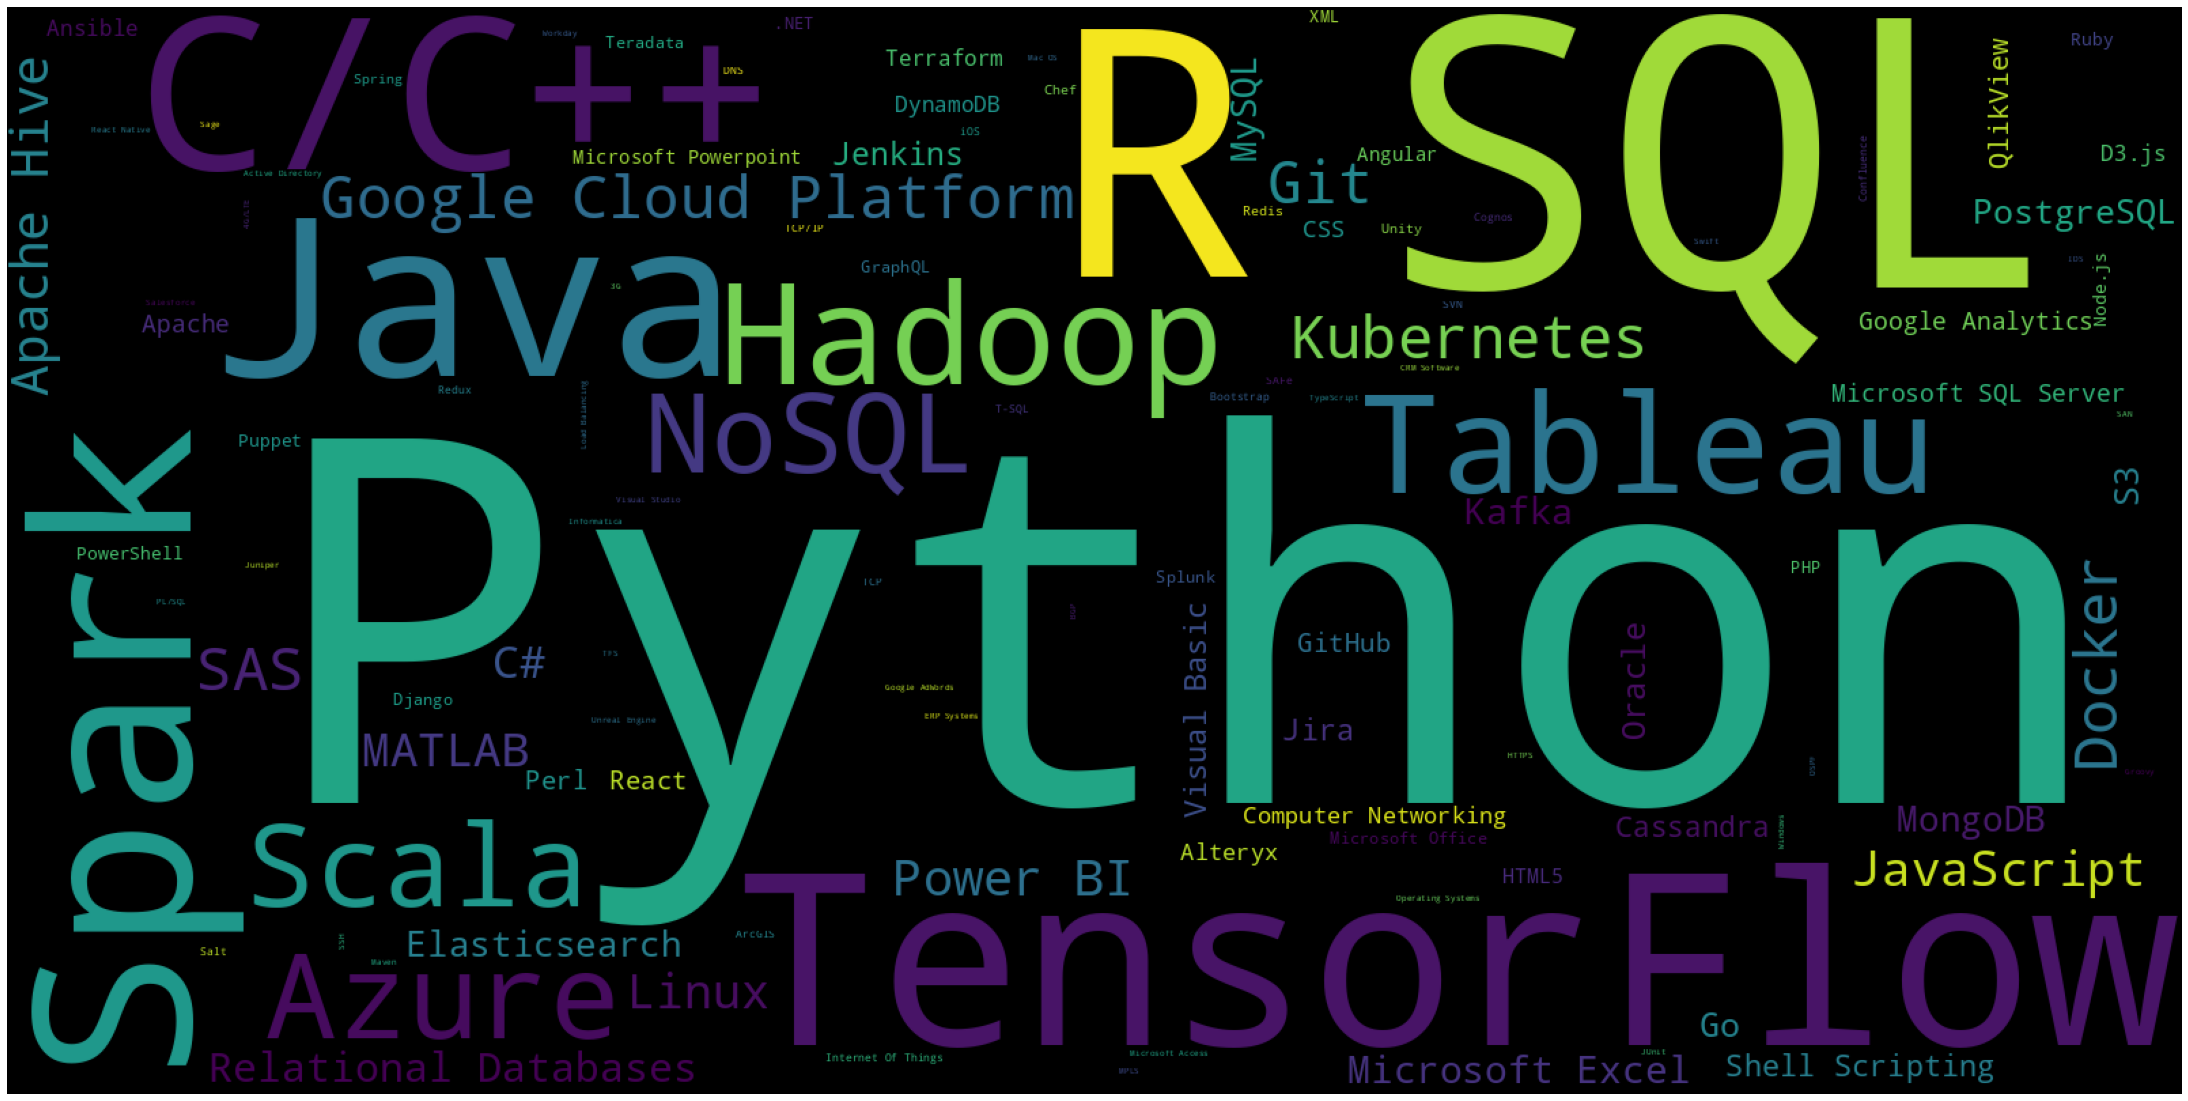

In [34]:
cloud = wordcloud.WordCloud(width=1600, height=800)
cloud.generate_from_frequencies(skill_frequency.to_dict())


plt.tight_layout(pad=0)
plt.figure(figsize=(40,20))
plt.axis('off')
plt.imshow(cloud)

We know from an earlier checks that a skill only exists once per job so where we see 560 for Python we know that there are 560 jobs that contain the skill Python therefore we can calculate the proportion of jobs that contain each skill

In [122]:
pd.DataFrame(skill_frequency[:10] / df_skills.shape[0] * 100,columns=['Relative Freq. %'])

,Relative Freq. %
Python,83.667180
SQL,39.753467
R,33.436055
TensorFlow,21.725732
Java,18.027735
Spark,17.719569
C/C++,16.795069
Hadoop,14.175655
Tableau,13.713405
Azure,10.015408


An impressive 83% of the jobs that specified skills require the Python skill, 39% SQL and 33% R

## Locations

In [129]:
pd.DataFrame({'Relative Freq. %' : (df_job_details.location.value_counts(normalize=True)[0:20]*100)})

,Relative Freq. %
London,54.228856
Cambridge,6.840796
Oxford,3.606965
Reading,2.363184
Manchester,2.238806
Belfast,1.990050
Edinburgh,1.990050
Home Based,1.741294
Bristol,1.492537
Glasgow,1.368159


<AxesSubplot:xlabel='Location', ylabel='Frequency'>

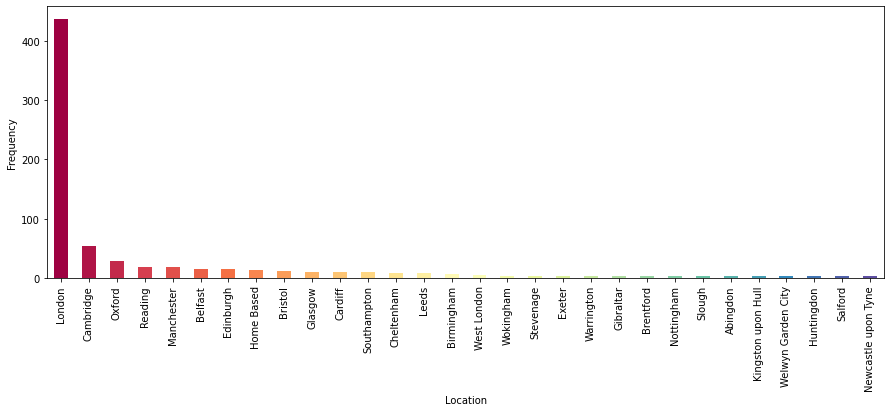

In [37]:
location_counts = df_job_details.location.value_counts()[:30]


colour_spectrum = [plt.cm.Spectral(i/float(len(location_counts)-1)) for i in range(len(location_counts))]

location_counts.plot(kind='bar',color=colour_spectrum,figsize=(15,5),xlabel='Location',ylabel='Frequency')

As expected London is the major centre for Data Science jobs, over 54% of the roles found were based here.

Home Based / Remote roles featured higher that I thought they might having a higher proportion than some major cities!

## Job Types

In [153]:
# any NaN job_types with a yearly salary could be inferred to be permanent; Contract jobs tend to be daily/hourly rates and permanent most often are yearly rates
# however these is a significant number of this and this may be too big of an assumption. 
# It would be useful to examine so create a new type for this scenario

df_job_details.loc[(df_job_details_PrePro['job_type'].isna()) & (df_job_details_PrePro['salary_expectation_per'].str.lower() == 'yearly'),['job_type']] = 'TENTATIVE_PERMANENT'

In [165]:
# Check all possible combinations of job_type present
df_job_details.job_type.apply(pd.Series).drop_duplicates()

,0,1,2
0,NaN,NaN,NaN
1,PERMANENT,NaN,NaN
3,TENTATIVE_PERMANENT,NaN,NaN
4,FULLTIME,PERMANENT,NaN
17,FULLTIME,PARTTIME,NaN
73,FULLTIME,CONTRACT,PERMANENT
75,CONTRACT,NaN,NaN
112,FULLTIME,CONTRACT,NaN
165,FULLTIME,PARTTIME,PERMANENT
191,FULLTIME,INTERNSHIP,NaN


In [185]:
# write a function to group job_types into categories I'm interested in. Essentially I want to know how the Data Science job market is split between Permanent and Contract
def get_job_type(job_type):
    """
    A function to help us summarise job types. For the analysis we are only interested in 
    """
    if 'TENTATIVE_PERMANENT' in job_type:
        return 'TENTATIVE_PERMANENT'
    elif ('PERMANENT' in job_type or 'FULLTIME' in job_type) and ('CONTRACT' in job_type or 'TEMPORARY' in job_type):
        return 'CONTRACT/TEMPORARY_OR_PERMANENT'
    elif ('PERMANENT' in job_type or 'FULLTIME' in job_type):
        return 'PERMANENT'
    elif ('CONTRACT' in job_type or 'TEMPORARY' in job_type):
        return 'CONTRACT/TEMPORARY'
    elif ('VOLUNTEER' in job_type or 'INTERNSHIP' in job_type or 'PARTTIME' in job_type):
        return 'OTHER'
    else:
        raise Exception(f'get_job_type cannot handle job_type {job_type}')

In [186]:
# take a data frame of job types excluding any rows where we have none specifed
df_job_details_with_job_type = df_job_details.loc[~df_job_details.job_type.isna()]

df_job_details_with_job_type.shape

(363, 12)

In [187]:
df_job_details_with_job_type_cleansed = df_job_details_with_job_type.job_type.apply(get_job_type)

In [188]:
df_job_details_with_job_type_cleansed.value_counts()

PERMANENT                          217
TENTATIVE_PERMANENT                107
CONTRACT/TEMPORARY                  23
OTHER                                9
CONTRACT/TEMPORARY_OR_PERMANENT      7
Name: job_type, dtype: int64

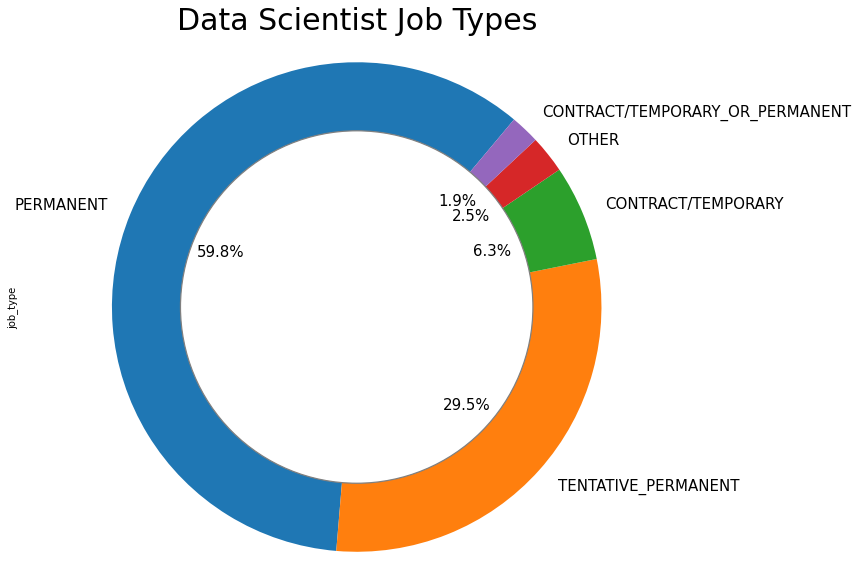

In [189]:
df_job_details_with_job_type_cleansed.value_counts().plot.pie(figsize=(12,10),startangle=50,autopct='%1.1f%%',fontsize=15)
plt.title("Data Scientist Job Types",fontsize=30)

#https://medium.com/@krishnakummar/donut-chart-with-python-matplotlib-d411033c960b
centre_circle = plt.Circle((0,0),0.72,color='gray', fc='white',linewidth=1.25)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.show()

Of the 364 job that specify a job type (or that we were able to infer from salary frequency or job title) over 90% are permanent roles!